In [1]:
from sys import path
import numpy as np
import os
import pandas as pd
from datetime import datetime as dt
import json
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
root_dir = "./"
input_dir = root_dir + "input_data"
output_dir = root_dir + "sample_result_submission"
program_dir = root_dir + "ingestion_program"
submission_dir = root_dir + "sample_code_submission"

path.append(input_dir)
path.append(output_dir)
path.append(program_dir)
path.append(submission_dir)



In [3]:
from systematics import Systematics

In [4]:
from model import Model

In [5]:
class Ingestion():

    def __init__(self, test_dir="test", use_systematics=True):

        self.test_dir = test_dir
        self.use_systematics = use_systematics

        # Initialize class variables
        self.start_time = None
        self.end_time = None
        self.model = None
        self.train_set = None
        self.test_sets = []


    def load_train_set(self):
        print("[*] Loading Train data")

        train_data_file = os.path.join(input_dir, 'train', 'data', 'data.csv')
        train_labels_file = os.path.join(input_dir, 'train', 'labels', "data.labels")
        train_settings_file = os.path.join(input_dir, 'train', 'settings', "data.json")

        # read train data
        train_data = pd.read_csv(train_data_file)


        # read trian labels
        with open(train_labels_file, "r") as f:
            train_labels = np.array(f.read().splitlines(), dtype=float)


        # # ------
        # # Train weights adjustment
        # # ------
        weights_train = deepcopy(train_data["Weight"])
        class_weights_train = (weights_train[train_labels == 0].sum(), weights_train[train_labels == 1].sum())

        for i in range(len(class_weights_train)): # loop on B then S target
            #training dataset: equalize number of background and signal
            weights_train[train_labels == i] *= max(class_weights_train)/ class_weights_train[i] 

        # reassign weight to data
        train_data["New_Weight"] = weights_train
        # ------
        

        # read train settings
        with open(train_settings_file) as f:
            train_settings = json.load(f)

        self.train_set = {
            "data": train_data,
            "labels": train_labels,
            "settings": train_settings
        }

    def load_test_sets(self):
        print("[*] Loading Test data")
        self.test_sets = []
        for i in range(0, 10):
            test_data_file = os.path.join(input_dir, self.test_dir, 'data', 'data_'+str(i)+'.csv')
            self.test_sets.append(pd.read_csv(test_data_file))

    def initialize_submission(self):
        print("[*] Initializing submitted model")
        self.model = Model(
            train_set=self.train_set,
            test_sets=self.test_sets,
            systematics=Systematics,
            use_systematics=self.use_systematics
        )

    def fit_submission(self):
        print("[*] Calling fit method of submitted model")
        self.model.fit()

    def predict_submission(self):
        print("[*] Calling predict method of submitted model")
        predicted_dict = self.model.predict()

        self.mu_hats = predicted_dict["mu_hats"]
        self.delta_mu_hat = predicted_dict["delta_mu_hat"]
        self.test_sets_decisions = predicted_dict["decisions"]
        self.test_sets_predictions = predicted_dict["predictions"]
        self.best_theta = predicted_dict["theta"]

    def save_result(self):

        print("[*] Saving result")

        result_dict = {
            "delta_mu_hat": self.delta_mu_hat,
            "mu_hats": self.mu_hats
        }
        print(f"[*] --- delta_mu_hat: {result_dict['delta_mu_hat']}")
        print(f"[*] --- mu_hats (avg): {np.mean(result_dict['mu_hats'])}")

        result_file = os.path.join(output_dir, "result.json")

        with open(result_file, 'w') as f:
            f.write(json.dumps(result_dict, indent=4))

    def plot_pair(self):
        sns.pairplot(self.train_set["data"])
        

    def plot_decisions(self):

        num_rows = 2

        fig, axes = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))  # Create subplots
        axes = axes.flatten()
        for i, (decisions, predictions) in enumerate(zip(self.test_sets_decisions, self.test_sets_predictions)):
            
            ax = axes[i]  # Handle single-row case

            ax.hist([decisions[predictions == 0], decisions[predictions == 1]], alpha=0.5, color=['blue', 'red'], label=['Label 0', 'Label 1'])
            ax.set_xlabel('Decisions')
            ax.set_ylabel('Frequency')
            ax.set_title(f'Test Set {i + 1} Decisions Histogram')
            ax.legend()

        plt.tight_layout()
        plt.show()

    def plot_weights(self):

        num_rows = 2

        fig, axes = plt.subplots(num_rows, 5, figsize=(15, num_rows * 3))  # Create subplots
        axes = axes.flatten()
        for i, (test_prediction, test_set) in enumerate(zip(self.test_sets_predictions, self.test_sets)):
            
            ax = axes[i]  # Handle single-row case
            weights_col = test_set["Weight"]
            signal_indexes = test_prediction == 1
            background_indexes = test_prediction == 0

            signal_weights = weights_col[signal_indexes].sum()
            background_weights = weights_col[background_indexes].sum()
            
            ax.bar("Signal", signal_weights, label="Signal")
            ax.bar("Background", background_weights, label="Background")
            ax.set_yscale("log")
            ax.set_xlabel('Labels')
            ax.set_ylabel('Sum of Weight')
            ax.set_title(f'Test Set {i + 1} Sum of Weights')
            ax.legend()

        plt.tight_layout()
        plt.show()


    def do_all(self):
        # load test set
        self.load_train_set()

        # load test set
        self.load_test_sets()

        # Initialize submission
        self.initialize_submission()

        # Call fit method of submission
        self.fit_submission()

        # Call predict method of submission
        self.predict_submission()

        # self.plot_pair()

        # decision function plot
        self.plot_decisions()

        self.plot_weights()



[*] Loading Train data
[*] Loading Test data
[*] Initializing submitted model
[*] Calling fit method of submitted model
[*] - Generating Validation sets
[*] - Train a classifier
[*] --- Loading Model
[*] --- Training Model
[*] --- Predicting Train set
[*] Choose best theta
[*] --- Best theta : -5
[*] - Computing Validation result
118337
50717
n_roi: 2035.7888084439999 --- nu_roi: 4729.98691703 --- gamma_roi: 992017.5279400299
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_hat: 0.003
118337
50717
n_roi: 2035.7888084439999 --- nu_roi: 4729.98691703 --- gamma_roi: 992017.5279400299
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_hat: 0.003
118337
50717
n_roi: 2035.7888084439999 --- nu_roi: 4729.98691703 --- gamma_roi: 992017.5279400299
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_hat: 0.003
118337
50717
n_roi: 2035.7888084439999 --- nu_roi: 4729.98691703 --- gamma_roi: 992017.5279400299
[*] --- mu: 1.0 --- mu_hat: 0.997 --- delta_mu_hat: 0.003
118337
50717
n_roi: 2035.7888084439999 --- n

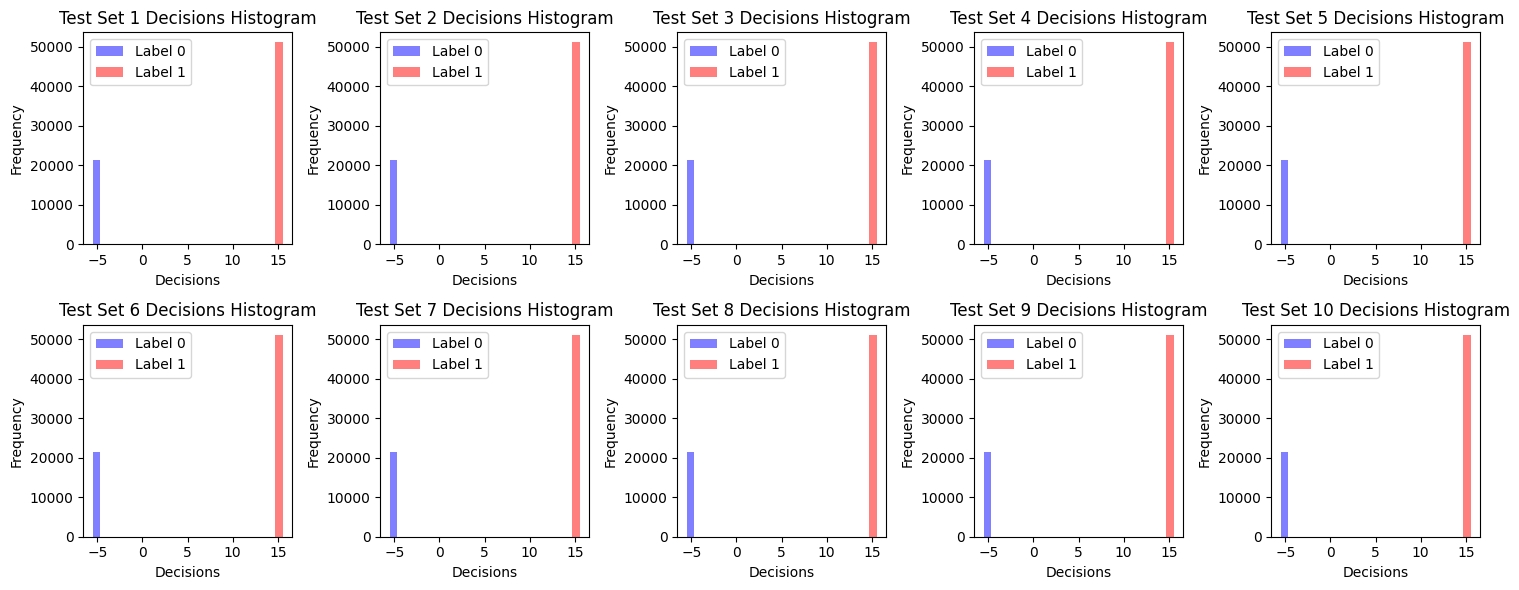

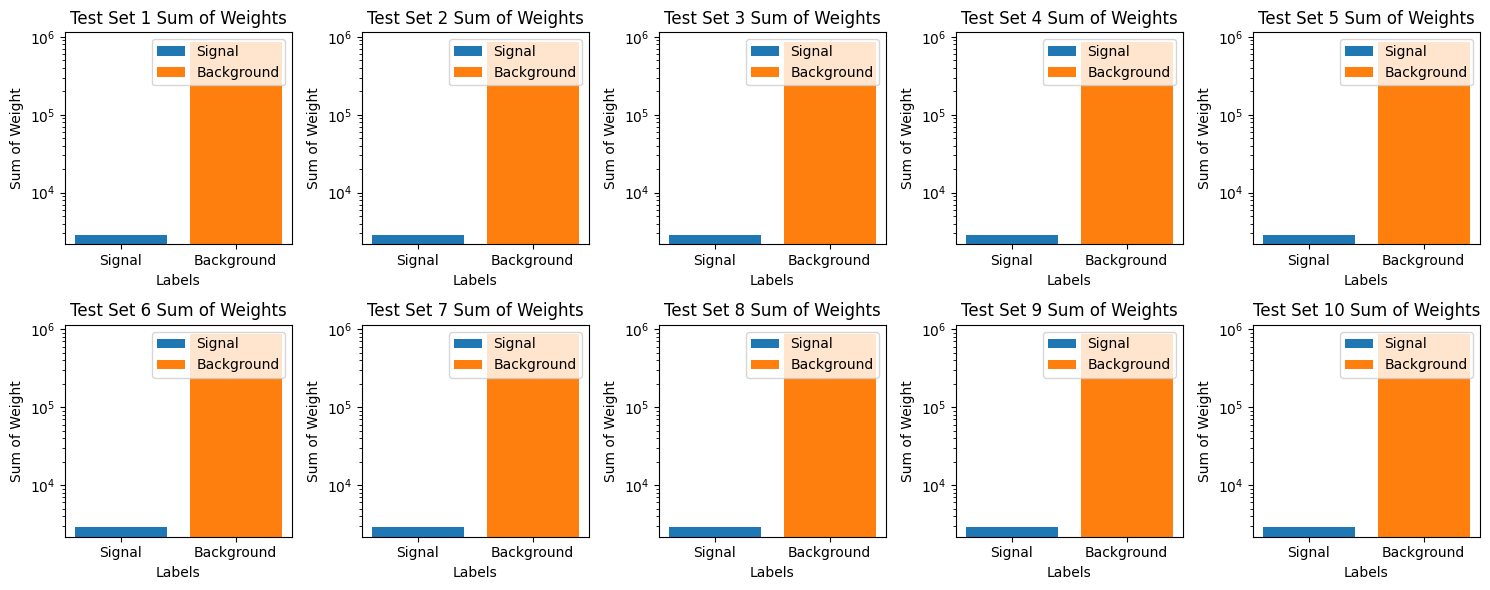

In [6]:
ingestion = Ingestion(test_dir="test_no_sys", use_systematics=False)
ingestion.do_all()

In [7]:

# ingestion = Ingestion(test_dir="test")
# ingestion.do_all()